# Quantum Selected Configuration Interaction (QSCI)法による基底状態計算

このノートブックでは、Quantum selected configuration interaction (QSCI)法[1]を使って分子系のエネルギーを求める。

QSCI法では、以下のような手順で系のエネルギーを求める。

0. VQEなどを活用し量子状態を用意する。
1. ビット列のサンプリングを行う。
2. サンプルされた計算基底が張る部分空間の有効ハミルトニアンを構築する。
3. 有効ハミルトニアンを対角化する。

単純化したコードを準備したので、順番に実行していこう。


In [ ]:
%pip install openfermion --upgrade
%pip install h5py --upgrade
%pip install openfermionpyscf qulacs scipy
%pip install py3Dmol

## 0. VQEなどを活用し量子状態を用意する。

05_03「量子変分固有値法（VQE）を用いた基底状態計算」の中身を再度実行し、量子状態 $|\Psi\rangle$ を用意する。（本ノートブックで行っている計算は全て、従来型の（古典）コンピュータ上でのシミュレーションです。）

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev, symmetry_conserving_bravyi_kitaev
from openfermion.ops import FermionOperator
from pyscf import gto, scf, tools
from qchem_util import get_molecular_hamiltonian_from_fcidump
from qulacs.observable import create_observable_from_openfermion_text
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import X, RY, CNOT, merge, RY

HF計算を実行し、ハミルトニアンを準備する。

In [ ]:
mol = gto.M(atom = 'H 0 0 0; H 0 0 0.74', basis = 'sto-3g')
mf = scf.RHF(mol)
mf.verbose = 0
hf_energy = mf.kernel()
# 第二量子化された電子のハミルトニアンを構築し、fcidump 形式で保存
tools.fcidump.from_scf(mf, 'fcidump.rhf') 
# OpenFermionに第二量子化されたハミルトニアンをロード
fermion_hamiltonian = get_fermion_operator(get_molecular_hamiltonian_from_fcidump('fcidump.rhf'))
# Jordan-Wigner変換を行う
jw_qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
print (jw_qubit_hamiltonian)

Parsing fcidump.rhf
(-0.0970662681676308+0j) [] +
(-0.04530261550379926+0j) [X0 X1 Y2 Y3] +
(0.04530261550379926+0j) [X0 Y1 Y2 X3] +
(0.04530261550379926+0j) [Y0 X1 X2 Y3] +
(-0.04530261550379926+0j) [Y0 Y1 X2 X3] +
(0.17141282644776878+0j) [Z0] +
(0.16868898170361207+0j) [Z0 Z1] +
(0.12062523483390412+0j) [Z0 Z2] +
(0.16592785033770338+0j) [Z0 Z3] +
(0.1714128264477688+0j) [Z1] +
(0.16592785033770338+0j) [Z1 Z2] +
(0.12062523483390412+0j) [Z1 Z3] +
(-0.22343153690813433+0j) [Z2] +
(0.17441287612261566+0j) [Z2 Z3] +
(-0.22343153690813428+0j) [Z3]


In [5]:
n_qubit = 4 
hf_state = QuantumState(n_qubit) # 4qubitの量子状態を用意。この時点では|0000> 
hf_state.set_computational_basis(int('0b0011',2)) # |0011>を用意

In [6]:
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_qubit_hamiltonian))

In [63]:
print("HF energy:", hf_energy)
qulacs_hamiltonian.get_expectation_value(hf_state)

HF energy: -1.1167593073964255


-1.1167593073964242

HF状態によるハミルトニアンの期待値は確かにHF energyを再現している。

VQEも同様に再実行していこう。

In [64]:
def create_A_gate(theta, target_two_qubits):
  first = target_two_qubits[0]
  second = target_two_qubits[1]
  CNOT02 = CNOT(first, second)
  CRY0 = RY(first, theta+np.pi/2)
  CRY0_minus = RY(first, -(theta+np.pi/2))
  CNOT20 = CNOT(second, first)
  return merge(merge(merge(merge(CNOT02, CRY0), CNOT20), CRY0_minus), CNOT02)

In [65]:
print (create_A_gate(0.0, [0, 2]))

 *** gate info *** 
 * gate name : DenseMatrix
 * target    : 
 0 : commute       
 2 : commute       
 * control   : 
 * Pauli     : no
 * Clifford  : no
 * Gaussian  : no
 * Parametric: no
 * Diagonal  : no
 * Matrix
          (1,0)           (0,0)           (0,0)           (0,0)
          (0,0)           (1,0) (2.22045e-16,0)           (0,0)
          (0,0) (2.22045e-16,0)          (-1,0)           (0,0)
          (0,0)           (0,0)           (0,0)           (1,0)



In [66]:
n_repeat = 2 #量子回路の深さ
def cost(parameters):
    #初期波動関数の用意
    n_qubit = 4 
    state = QuantumState(n_qubit) # 4qubitの量子状態を用意。この時点では|0000> 
    state.set_computational_basis(int('0b0011',2)) # |0011>を用意
    #ansatz(量子回路を用意)
    num_paras = len(parameters)
    ansatz = QuantumCircuit(n_qubit)
    for i in range(n_repeat):
        idx = 2*i 
        ansatz.add_gate(create_A_gate(parameters[idx], [0, 2]))
        ansatz.add_gate(create_A_gate(parameters[idx+1], [1, 3]))
        ansatz.add_gate(create_A_gate(parameters[idx], [1, 2]))
    #近似波動関数の生成
    ansatz.update_quantum_state(state)
    return qulacs_hamiltonian.get_expectation_value(state) #エネルギーを返す。

Convderged VQE Energy (in hartree) -1.1371944668021448
c.f., Full CI Energy (in hartree)  -1.1372838344885023


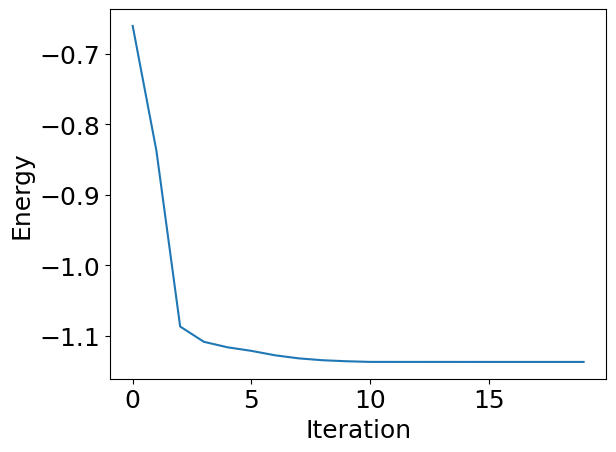

In [67]:
import scipy.optimize

cost_history = []

#パラメータの初期値
init_theta_list = [np.random.random() for i in range(n_repeat*2)]
#init_theta_list = [0.1 for i in range(n_repeat*2)]
cost_history.append(cost(init_theta_list))

method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}

opt = scipy.optimize.minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

#print (cost_history)
print ("Convderged VQE Energy (in hartree)", cost_history[-1])
print ("c.f., Full CI Energy (in hartree)  -1.1372838344885023")
plt.rcParams["font.size"] = 18
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()

VQEを実行できた。

## 1. ビット列のサンプリングを行う。

最適化後のパラメータを回路に代入し、量子状態を用意する。

In [12]:
def get_state(parameters):
    #初期波動関数の用意
    n_qubit = 4 
    state = QuantumState(n_qubit) # 4qubitの量子状態を用意。この時点では|0000> 
    state.set_computational_basis(int('0b0011',2)) # |0011>を用意
    #ansatz(量子回路を用意)
    num_paras = len(parameters)
    ansatz = QuantumCircuit(n_qubit)
    for i in range(n_repeat):
        idx = 2*i 
        ansatz.add_gate(create_A_gate(parameters[idx], [0, 2]))
        ansatz.add_gate(create_A_gate(parameters[idx+1], [1, 3]))
        ansatz.add_gate(create_A_gate(parameters[idx], [1, 2]))
    #近似波動関数の生成
    ansatz.update_quantum_state(state)
    return state 

最適化後のパラメータは以下である。

In [13]:
opt.x

array([ 0.2479935 , -0.24298693,  0.23120636, -0.22257288])

In [14]:
state = get_state(opt.x)

sampling関数を使って、量子状態からビット列をサンプリングする。

In [ ]:
n_shots = 100000

import collections
samples = state.sampling(n_shots)
sampling_result = collections.Counter(samples)
sampling_result

Counter({3: 98735, 12: 1253, 10: 10, 6: 1, 5: 1})

サンプルされたビット列（十進数表示）とその頻度が辞書型オブジェクトにまとめられている。

HF状態、`int('0b0011',2) = 3`の頻度が非常に大きいことがわかる。

In [68]:
# キーだけをリスト化
config_list = list(sampling_result.keys())
print(config_list)

[3, 12, 10, 6, 5]


## 2. サンプルされた計算基底が張る部分空間の有効ハミルトニアンを構築する。

実際にビット列をサンプルできた。ここからは、サンプリングされた計算基底 $\{|\Phi_i\rangle\}$ が張る部分空間における有効ハミルトニアン $\hat{H}^{\textrm{eff}}$ を構築する。

有効ハミルトニアンの行列要素は
$$
\hat{H}^{\textrm{eff}}_{ij} = \langle \Phi_i | \hat{H} | \Phi_j \rangle
$$
である。

わかりやすさのために、ハミルトニアンを行列の形にする。

In [50]:
from openfermion.linalg import get_sparse_operator
jw_hamiltonian_sparse = get_sparse_operator(jw_qubit_hamiltonian)
jw_hamiltonian_array = jw_hamiltonian_sparse.toarray()

以下の関数を使って、元の行列 $\hat{H}$ から、サンプルされたインデックスのみを使って小さな行列 $\hat{H}^{\textrm{eff}}$ を作る。

In [ ]:
def effective_Hamiltonian_construction(configs, H_matrix_array):
    """
    Constuct effective Hamiltonian matrix using configs
    Args:
        configs: Configurations lists.
        H_matrix_array: Jordan-Wigner transformed Hamiltonian matrix
    Returns:
        Heff_matrix_array: Effective Hamiltonian matrix, which contains sampled computational bases block.
    """
    Heff_matrix_array = np.zeros((len(configs), len(configs)))  # Initialize the Heff matrix

    for i_eff, idx_i in enumerate(configs):
        for j_eff, idx_j in enumerate(configs):
            Heff_matrix_array[i_eff, j_eff] = H_matrix_array[idx_i, idx_j]

    return Heff_matrix_array

（実は、用意した行列のビット列の並びの定義がこれまでと反対になってしまっているので、ビット列を反転させておく。）

In [54]:
def invert_configs_bit_order(configs, total_bits):
    """
    Inverts the order of bits in the configuration integer.

    Args:
        configs: Integer representing the electron configuration bitstrings.
        total_bits: Total number of bits in the configuration (e.g., 2*nbits for up and down spins).

    Returns:
        Integer lists whose binary representation is the reverse of the original.
        
    Example:
        # For nbits=2, total_bits=4. Suppose config_int corresponds to the bit string "1010".
        # The reversed bit string is "0101", which equals 5 in decimal.
        result = invert_config_bit_order(10, 4)  # 10 == "1010" -> reversed -> "0101" -> 5
    """
    invert_configs = []
    for config_int in configs:
        # Convert to a fixed-length bit string with leading zeros.
        bit_str = format(config_int, f'0{total_bits}b')
        # Reverse the bit string.
        reversed_str = bit_str[::-1]
        # Convert the reversed bit string back to an integer.
        invert_configs.append(int(reversed_str, 2))
    return invert_configs

In [69]:
invert_config_list = invert_configs_bit_order(config_list, total_bits=state.get_qubit_count())
invert_config_list

[12, 3, 5, 6, 10]

In [72]:
jw_Heff_array = effective_Hamiltonian_construction(invert_config_list, jw_hamiltonian_array)

/var/folders/j6/x72n0mcn26g2m2nmv506b9rh0000gn/T/ipykernel_20042/1358725023.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  Heff_matrix_array[i_eff, j_eff] = H_matrix_array[idx_i, idx_j]


元のハミルトニアン $\hat{H}$ と 有効ハミルトニアン $\hat{H}^{\textrm{eff}}$ の行列サイズをそれぞれ確認してみよう。

In [79]:
print("元のハミルトニアンの行列サイズ：", jw_hamiltonian_array.shape)
print("有効ハミルトニアンの行列サイズ：", jw_Heff_array.shape)

元のハミルトニアンの行列サイズ： (16, 16)
有効ハミルトニアンの行列サイズ： (5, 5)


元のハミルトニアンの行列サイズは $2^4 \times 2^4$ であるのに対し、サンプルされたビット列のみを使って小さなハミルトニアン行列を構築できていることがわかる。

## 3. 有効ハミルトニアンを対角化する。

あとは構築した有効ハミルトニアンを対角化するだけである。


In [56]:
eigen_energies, eigen_vectors = np.linalg.eigh(jw_Heff_array)

In [61]:
print("QSCI Energy (in hartree)", eigen_energies[0])
print ("c.f., Full CI Energy (in hartree)  -1.1372838344885023")

QSCI Energy (in hartree) -1.1372838344885006
c.f., Full CI Energy (in hartree)  -1.1372838344885023


今回の対角化結果は厳密解を再現していることがわかる。

これは、有効ハミルトニアンが基底状態を再現するのに必要なビット列の全てを使って構成されているからである。

## 参考文献
[1] K. Kanno, et al., arXiv:2302.11320.